# Diffusion Model test

In [7]:
import torch_geometric
import dgl
import random
import torch
from torch.utils.data import DataLoader
import numpy as np
import importlib

# Args

In [2]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--subgraph_size', type=int, default=32)
parser.add_argument('--num_save', type=int, default=50)
parser.add_argument('--file', type=str, default="./out.csv")
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--timesteps', type=int, default=400)
parser.add_argument('--lr', type=float, default=1e-2)
parser.add_argument('--schedule', type=str, default='linear', choices=[
    "cosine", "linear", "quadratic", "sigmoid"
])
parser.add_argument('--epochs', type=int, default=5)
parser.add_argument('--method', type=str, default='cluster', choices=[
    'walk', 'rand', 'cluster'
])
parser.add_argument('--dataset', type=str, default='cora', choices=[
    'cora', 'chameleon', 'BlogCatalog', 'flickr'
])

args = parser.parse_args("")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

# Load Data

In [17]:
import lib.data.dataloader as dataloader
importlib.reload(selection)
g = dataloader.load_DGL(args.dataset)

subgraph_size = args.subgraph_size
batch_size = args.batch_size
timesteps = args.timesteps

import lib.util.selection as selection
method = selection.get_selection(args.method)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [18]:
dataset = []
channels = 1
for i in range(batch_size * 25):
    dataset.append({"pixel_values" : (method(subgraph_size, g).adj().to_dense().unsqueeze(0) * 2) - 1})

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model

In [20]:
from torch.optim import Adam
from lib.model import unet
import torch

model = unet.Unet(
    dim=subgraph_size,
    channels=channels,
    dim_mults=(1, 2, 4, 8)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [21]:
import importlib
importlib.reload(unet)

scheduler = unet.get_scheduler(args.schedule)

unet.trainUnet(
    model=model,
    epochs=args.epochs,
    dataloader=dataloader,
    optimizer=Adam(model.parameters(), lr=1e-3),
    device=device,
    timesteps=timesteps,
    scheduler=scheduler
)

Epoch: 0


Batch: 100%|██████████| 50/50 [00:09<00:00,  5.21it/s, loss=0.296]


Epoch: 1


Batch: 100%|██████████| 50/50 [00:08<00:00,  6.14it/s, loss=0.114]


Epoch: 2


Batch: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s, loss=0.0794]


Epoch: 3


Batch: 100%|██████████| 50/50 [00:07<00:00,  6.38it/s, loss=0.0519]


Epoch: 4


Batch: 100%|██████████| 50/50 [00:07<00:00,  6.44it/s, loss=0.0445]


# Show a sample generated from pure noise

In [29]:
import matplotlib.pyplot as plt
plt.figure()
n = 50
print(f"Timesteps={timesteps}, showing increments of n={n}")
def showAll(imgs, size=16):
    ct = len(imgs)
    f, axarr = plt.subplots(1, ct, figsize=(size,size))
    for i in range(ct):
        col = axarr[i].imshow(imgs[i])
        axarr[i].axis('off')
    # f.colorbar(col, ax=axarr[-1])

def mirror(A: np.ndarray):
    return np.tril(A) + np.triu(A.T, 1)

Timesteps=400, showing increments of n=50


<Figure size 432x288 with 0 Axes>

sampling loop time step: 100%|██████████| 400/400 [00:05<00:00, 71.01it/s]


Generating from noise with timesteps=400 (showing n=50)


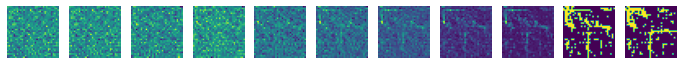

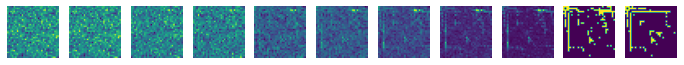

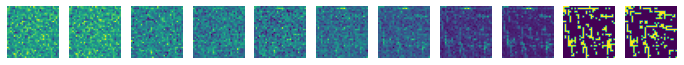

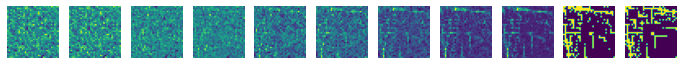

In [30]:
ct = 4
n = 50
rand_noise = torch.randn((ct, channels, subgraph_size, subgraph_size))

generated_samples = unet.sample_from(
    model, 
    image_size=subgraph_size, 
    initial_images=rand_noise.to(device), 
    channels=channels, 
    scheduler=scheduler, 
    timesteps=timesteps,
    num_steps=timesteps
)

print(f"Generating from noise with timesteps={timesteps} (showing n={n})")
for k in range(ct):
    pics = [rand_noise[k].squeeze()]
    for i in range(int(len(generated_samples) / n)):
        cur = generated_samples[i * n][k].squeeze()
        pics.append(cur)
    pics.append(generated_samples[-1][k].squeeze() > 0)
    pics.append(mirror(pics[-1]))
    showAll(pics, size=12)

# Show a sample generated from a sample

In [31]:
from tqdm import tqdm
import torch.nn.functional as F

for x in dataloader:
    print(x['pixel_values'].shape)
    break

def addNoise(x_start, device, steps, timesteps, scheduler):
    def q_sample(x_start, t, betas, noise=None):
        def extract(a, t, x_shape):
            batch_size = t.shape[0]
            out = a.gather(-1, t.cpu())
            return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
            
        if noise is None:
            noise = torch.randn_like(x_start)

        # define alphas 
        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
        sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(
            sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    
    t = torch.full((x_start.shape[0],), steps).cpu()
    x_noisy = q_sample(x_start=x_start, t=t, betas=scheduler(timesteps=timesteps), noise=None)

    return x_noisy

torch.Size([256, 1, 32, 32])


In [32]:
sample_graphs = []

def get_sample():
    return method(subgraph_size, g)

def to_img(graph):
    return (graph.adj().to_dense().unsqueeze(0) * 2) - 1

ct = 256
target = 200
n = 50
clean_samples = torch.zeros(ct, channels, subgraph_size, subgraph_size)
for i in range(ct):
    graph = get_sample()
    sample_graphs.append(graph)
    clean_samples[i] = to_img(graph)

noisy_samples = addNoise(
    x_start=clean_samples,
    device=device,
    steps=target,
    timesteps=timesteps,
    scheduler=scheduler
)

pure_samples = unet.sample_from(
    model, 
    image_size=subgraph_size, 
    initial_images=noisy_samples.to(device), 
    channels=channels, 
    scheduler=scheduler, 
    timesteps=timesteps,
    num_steps=target
)

sampling loop time step: 100%|██████████| 200/200 [00:07<00:00, 25.36it/s]


Adding timesteps=200 of noise to sample, then purifying with timesteps=200 (showing n=50)


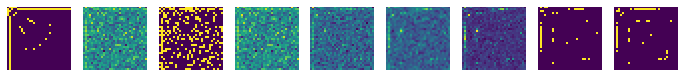

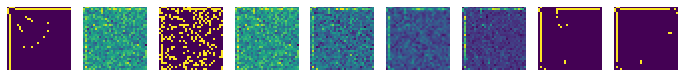

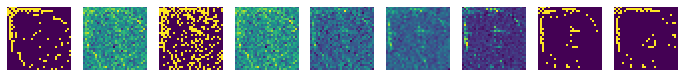

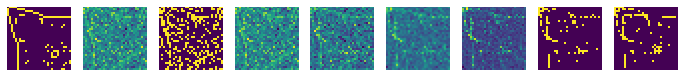

In [33]:
print(f"Adding timesteps={target} of noise to sample, then purifying with timesteps={target} (showing n={n})")
for k in range(4):
    pics = [clean_samples[k].squeeze()]
    pics.append(noisy_samples[k].squeeze())
    pics.append(noisy_samples[k].squeeze() > 0)
    # pics.append(torch.ones_like(clean_samples[k].squeeze()))
    for i in range(int(len(pure_samples) / n)):
        cur = pure_samples[i * n][k].squeeze()
        pics.append(cur)
    pics.append(pure_samples[-1][k].squeeze() > 0)
    pics.append(mirror(pics[-1]))
    showAll(pics, size=12)

In [43]:
from lib.model import DenseGCN
from lib.model import SimpleMLP

sample_graphs # [Dgl.graph]

clean_samples # Tensor ~ (256, 1, 16, 16)
noisy_samples # Tensor ~ (256, 1, 16, 16)
pure_samples # Tensor ~ (256, 1, 16, 16)

test_graphs = [] # [Dgl.graph]
for i in range(ct):
    graph = get_sample()
    test_graphs.append(graph)

# def get_gcn_acc(graphs, adj_imgs, test_graphs):
graphs=sample_graphs
adj_imgs=clean_samples
test_graphs=test_graphs
gcn = DenseGCN.DenseGCN(
    in_size=g.ndata['feat'].shape[1],
    hid_size=32,
    out_size=int(g.ndata['label'].max() + 1),
    lr=1e-3
)

mlp = SimpleMLP.SimpleMLP(
    in_size=g.ndata['feat'].shape[1],
    hid_size=32,
    out_size=int(g.ndata['label'].max() + 1),
    lr=1e-3,
    dropout=0.5,
    weight_decay=0.01
)

for i in range(5):
    print(f"epoch: {i}")
    for k, graph in enumerate(graphs):
        diag = torch.zeros_like(graph.adj().to_dense())
        diag.fill_diagonal_(1)
        gcn.fit(
            feat=graph.ndata['feat'],
            adj=diag,
            # adj=adj_imgs[k].squeeze(),
            labels=graph.ndata['label'],
            epochs=1,
            verbose=False
        )
        mlp.fit(
            feat=graph.ndata['feat'],
            # adj=adj_imgs[k].squeeze(),
            labels=graph.ndata['label'],
            epochs=1,
            verbose=False
        )

# get_gcn_acc(sample_graphs, clean_samples, test_graphs)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4


In [36]:
gcn = DenseGCN.DenseGCN(
    in_size=g.ndata['feat'].shape[1],
    hid_size=32,
    out_size=int(g.ndata['label'].max() + 1),
    lr=1e-2
)

gcn.fit(g.ndata['feat'], g.adj().to_dense(), g.ndata['label'], 200)

pred = gcn(g.ndata['feat'], g.adj().to_dense()).argmax(dim=1)
correct = (pred==g.ndata['label'])[g.ndata['test_mask']].sum().item()
print(f"acc: {correct / (g.ndata['test_mask'].sum()):.2%}")

GCN Training: 100%|██████████| 200/200 [00:01<00:00, 129.88it/s, loss=0.57]


acc: 85.30%


In [35]:
import importlib
import lib.util.selection as selection
importlib.reload(selection)

sample_graphs = []

def get_sample():
    return selection.subgraph_random(subgraph_size, g)

# def to_img(graph):
#     return (graph.adj().to_dense().unsqueeze(0) * 2) - 1

ct = 256
# target = 200
n = 50
clean_samples = torch.zeros(ct, channels, subgraph_size, subgraph_size)
for i in range(ct):
    sample_graphs.append(get_sample())
    # clean_samples[i] = to_img(graph)

In [37]:
sample_gcn = DenseGCN.DenseGCN(
    in_size=g.ndata['feat'].shape[1],
    hid_size=32,
    out_size=int(g.ndata['label'].max() + 1),
    lr=1e-3
)

out_loops = 2
in_loops = 5
for i in range(out_loops):
    for sample_graph in sample_graphs:
        sample_gcn.fit(
            sample_graph.ndata['feat'], 
            sample_graph.adj().to_dense(), 
            sample_graph.ndata['label'], 
            in_loops, verbose=False)

pred = sample_gcn(g.ndata['feat'], g.adj().to_dense()).argmax(dim=1)
correct = (pred==g.ndata['label'])[g.ndata['test_mask']].sum().item()
print(f"total epochs trained on {subgraph_size} node graph: {out_loops*len(sample_graphs)*in_loops}")
print(f"sample_gcn acc: {correct / (g.ndata['test_mask'].sum()):.2%}")

total epochs trained on 32 node graph: 2560
sample_gcn acc: 31.90%


In [40]:
test_graphs = [g]

In [44]:
correct = 0
total = 0
for t in test_graphs:
    pred = gcn(t.ndata['feat'], t.adj().to_dense()).argmax(dim=1)
    correct += (pred == t.ndata['label']).sum().item()
    total += t.num_nodes()
print(f"GCN acc: {correct / total:.2%}")

correct = 0
total = 0
for t in test_graphs:
    pred = mlp(t.ndata['feat']).argmax(dim=1)
    correct += (pred == t.ndata['label']).sum().item()
    total += t.num_nodes()
print(f"MLP acc: {correct / total:.2%}")

GCN acc: 30.55%
MLP acc: 30.30%


In [ ]:
from lib.model import DenseGCN
from lib.model import SimpleMLP

gcn = DenseGCN.DenseGCN(
    in_size=subgraph_size,
    hid_size=32,
    out_size=int(g.ndata['label'].max() + 1),
    lr=1e-3
)

# Misc

In [ ]:
train_data = [x["pixel_values"].squeeze() for x in dataset]

In [ ]:
start = torch.zeros((batch_size,channels,subgraph_size,subgraph_size))
for i in range(8):
    for j in range(8):
        start[0][0][i][j] = 1

out = addNoise(
    x_start=start,
    device=device,
    steps=0,
    timesteps=timesteps,
    scheduler=scheduler
)

print(start[0].mean(), start[0].var())
print(out[0].mean(), out[0].var())

showPic(start[0].squeeze())
showPic(out[0].squeeze())

tensor(0.2500) tensor(0.1882)
tensor(0.2504) tensor(0.1878)


NameError: name 'showPic' is not defined

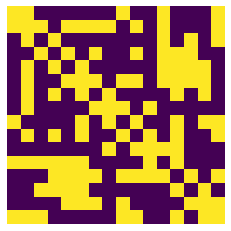

In [ ]:
import matplotlib.pyplot as plt

def showPics(num, imgs):
    plt.figure()
    f, axarr = plt.subplots(1, num, figsize=(15,15))
    rand = random.sample(range(len(imgs)), num)
    for i, imgIdx in enumerate(rand):
        # print(i['pixel_values'][0].squeeze().shape)
        axarr[i].imshow(imgs[imgIdx])
        axarr[i].axis('off')
        if i == num - 1: break


def showPic(img):
    plt.figure()
    # f, axarr = plt.subplots(1, 1, figsize=(15,15))
    # rand = random.sample(range(len(imgs)), num)
    plt.imshow(img)
    plt.axis('off')

def mirror(A: np.ndarray):
    return np.tril(A) + np.triu(A.T, 1)

train_data = [x["pixel_values"].squeeze() for x in dataset]
pred_data = [mirror(x.squeeze()) for x in (samples[-1].squeeze() > 0)]

# comparisons = 5
# showPics(comparisons, train_data)
# showPics(comparisons, pred_data)
showPic(pred_data[-1])